# 0. Import Library

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv("../data/train.csv")
df
df = df.drop(columns = ["Id"])

In [12]:
df.shape

(1460, 80)

# 1.Preproccessing
## 1.1. Missing value

In [13]:
temp = df.isna().sum(axis = 0) 
temp[temp > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Có 19 cột có dữ liệu khuyết, chia thành 3 nhóm:
- Các cột ít hơn 100 điểm khuyết
- 2 cột với 259 và 690 điểm khuyết, nhóm sẽ khảo sát các cột này
- Trên 1000 điểm khuyết, nhóm loại bỏ các cột ra khỏi dữ liệu

Cột LotFrontage, theo mô tả là độ dài phần đường tiếp xúc với ngôi nhà, hay độ dài mặt tiền. Đôi khi có những căn nhà không có đường chính nối tới, do đó có thể xuất hiện dữ liệu nan. Nhóm sẽ điền giá trị `0` và các giá trị này

Cột FireplaceQu, theo mô tả là chất lượng cơ sở vật chất chống cháy của tòa nhà, có 6 giá trị, trong đó giá trị nan mô tả nhà không có các thiết bị chống cháy. Nhóm sẽ thay thế các giá trị này bằng chuỗi `Na`

In [14]:
df = df.dropna(subset = [
    "MasVnrType", "MasVnrArea", "BsmtQual", "BsmtCond", "BsmtExposure", 
    "BsmtFinType1", "BsmtFinType2", "Electrical", "GarageType", "GarageYrBlt",
    "GarageFinish", "GarageQual", "GarageCond"
])

In [15]:
#xóa các cột nhiều giá trị null
df = df.drop(columns = ['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

In [16]:
#Điền giá trị null

df['LotFrontage'] = df['LotFrontage'].fillna(0)
df['FireplaceQu'] = df['FireplaceQu'].fillna('Na')

In [17]:
temp = (df == 0).sum(axis = 0)
temp[temp > 0]

LotFrontage       244
MasVnrArea        760
BsmtFinSF1        392
BsmtFinSF2       1176
BsmtUnfSF          73
2ndFlrSF          748
LowQualFinSF     1320
BsmtFullBath      764
BsmtHalfBath     1258
FullBath            8
HalfBath          808
BedroomAbvGr        6
Fireplaces        591
WoodDeckSF        669
OpenPorchSF       573
EnclosedPorch    1155
3SsnPorch        1315
ScreenPorch      1222
PoolArea         1331
MiscVal          1291
dtype: int64

In [18]:
temp[temp > 100].index

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

Khi khảo sát các cột numerical, xuất hiện các cột có số lượng dữ liệu `0` lớn, từ hơn 700 đến 1400 điểm, tức là từ 50 tới 100% dữ liệu

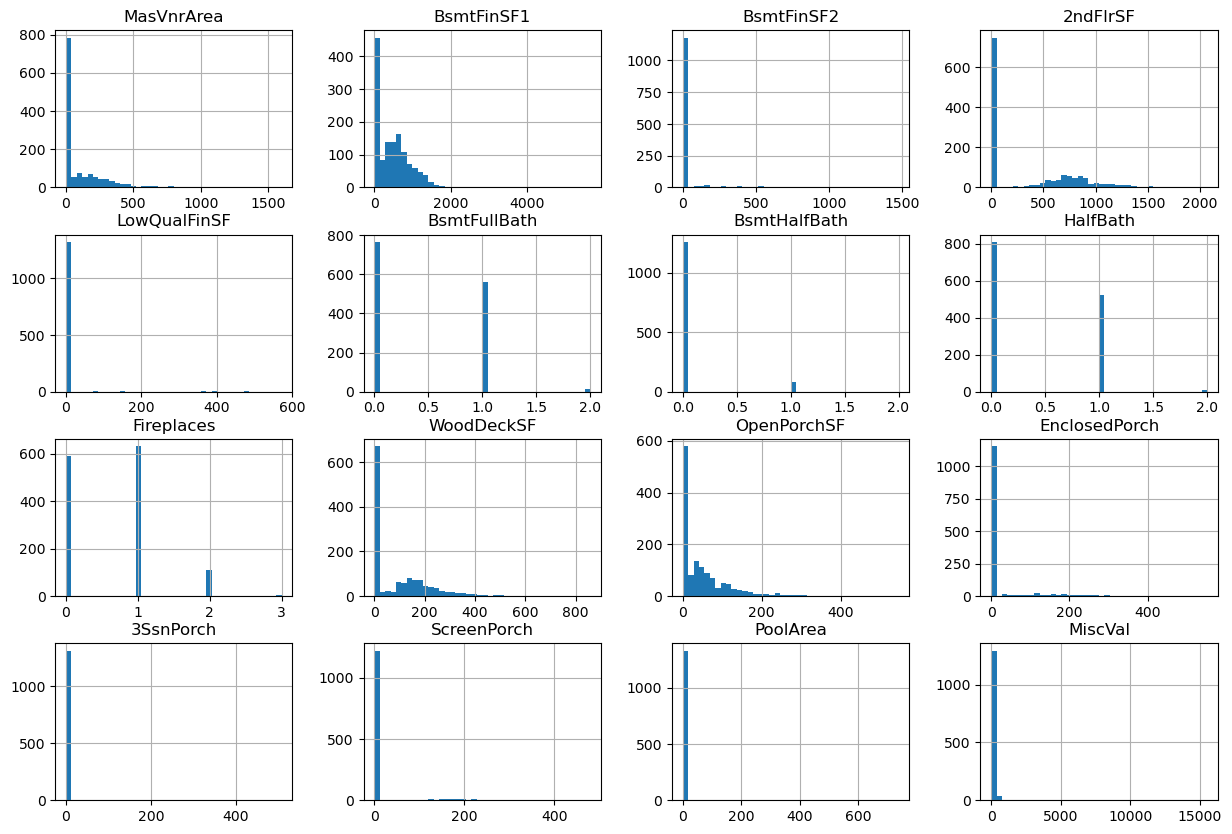

In [19]:
df[['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']].hist(bins = 40, figsize = (15, 10));

Các cột được chia thành các nhóm sau:

- Các cột numerical mang ý nghĩa liên tục có dữ liệu bị nhiều về 0, các cột `MasVnrArea`, `BsmtFinSF1`, `BsmtFinSF2`, `2ndFlrSF`, `LowQuaIFinSF`, `WoodDeckSF`, `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`, `PoolArea`, `MiscVal`

- Các cột numerical nhưng mang ý nghĩa rời rạc: `BsmtFullBath`, `BsmtHaflBath`, `HalfBath`, `Fireplaces`. Dữ liệu ở các cột này phân bố khá đồng đều, trừ cột `BsmtHalfBath` dữ liệu bị lệch nhiều về 0.

Nhóm quyết định loại bỏ các cột dữ liệu bị lệch về 0 đã đề cập ở trên

In [20]:
df = df.drop(columns = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '2ndFlrSF',
       'LowQualFinSF', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'])

In [21]:
df = df.reset_index(drop = True)

## 1.2. Duplicated values

In [22]:
df.duplicated().sum()

0

## 1.3. Outliers

### 1.3.1 Categorical outliers

In [23]:
dftypes = df.dtypes
categorical_col = list(dftypes[dftypes == "object"].keys())
categorical_col.append("MSSubClass")
categorical_col.append("KitchenAbvGr")

numerical_col = list(df.columns[~df.columns.isin(categorical_col)])[:-1]

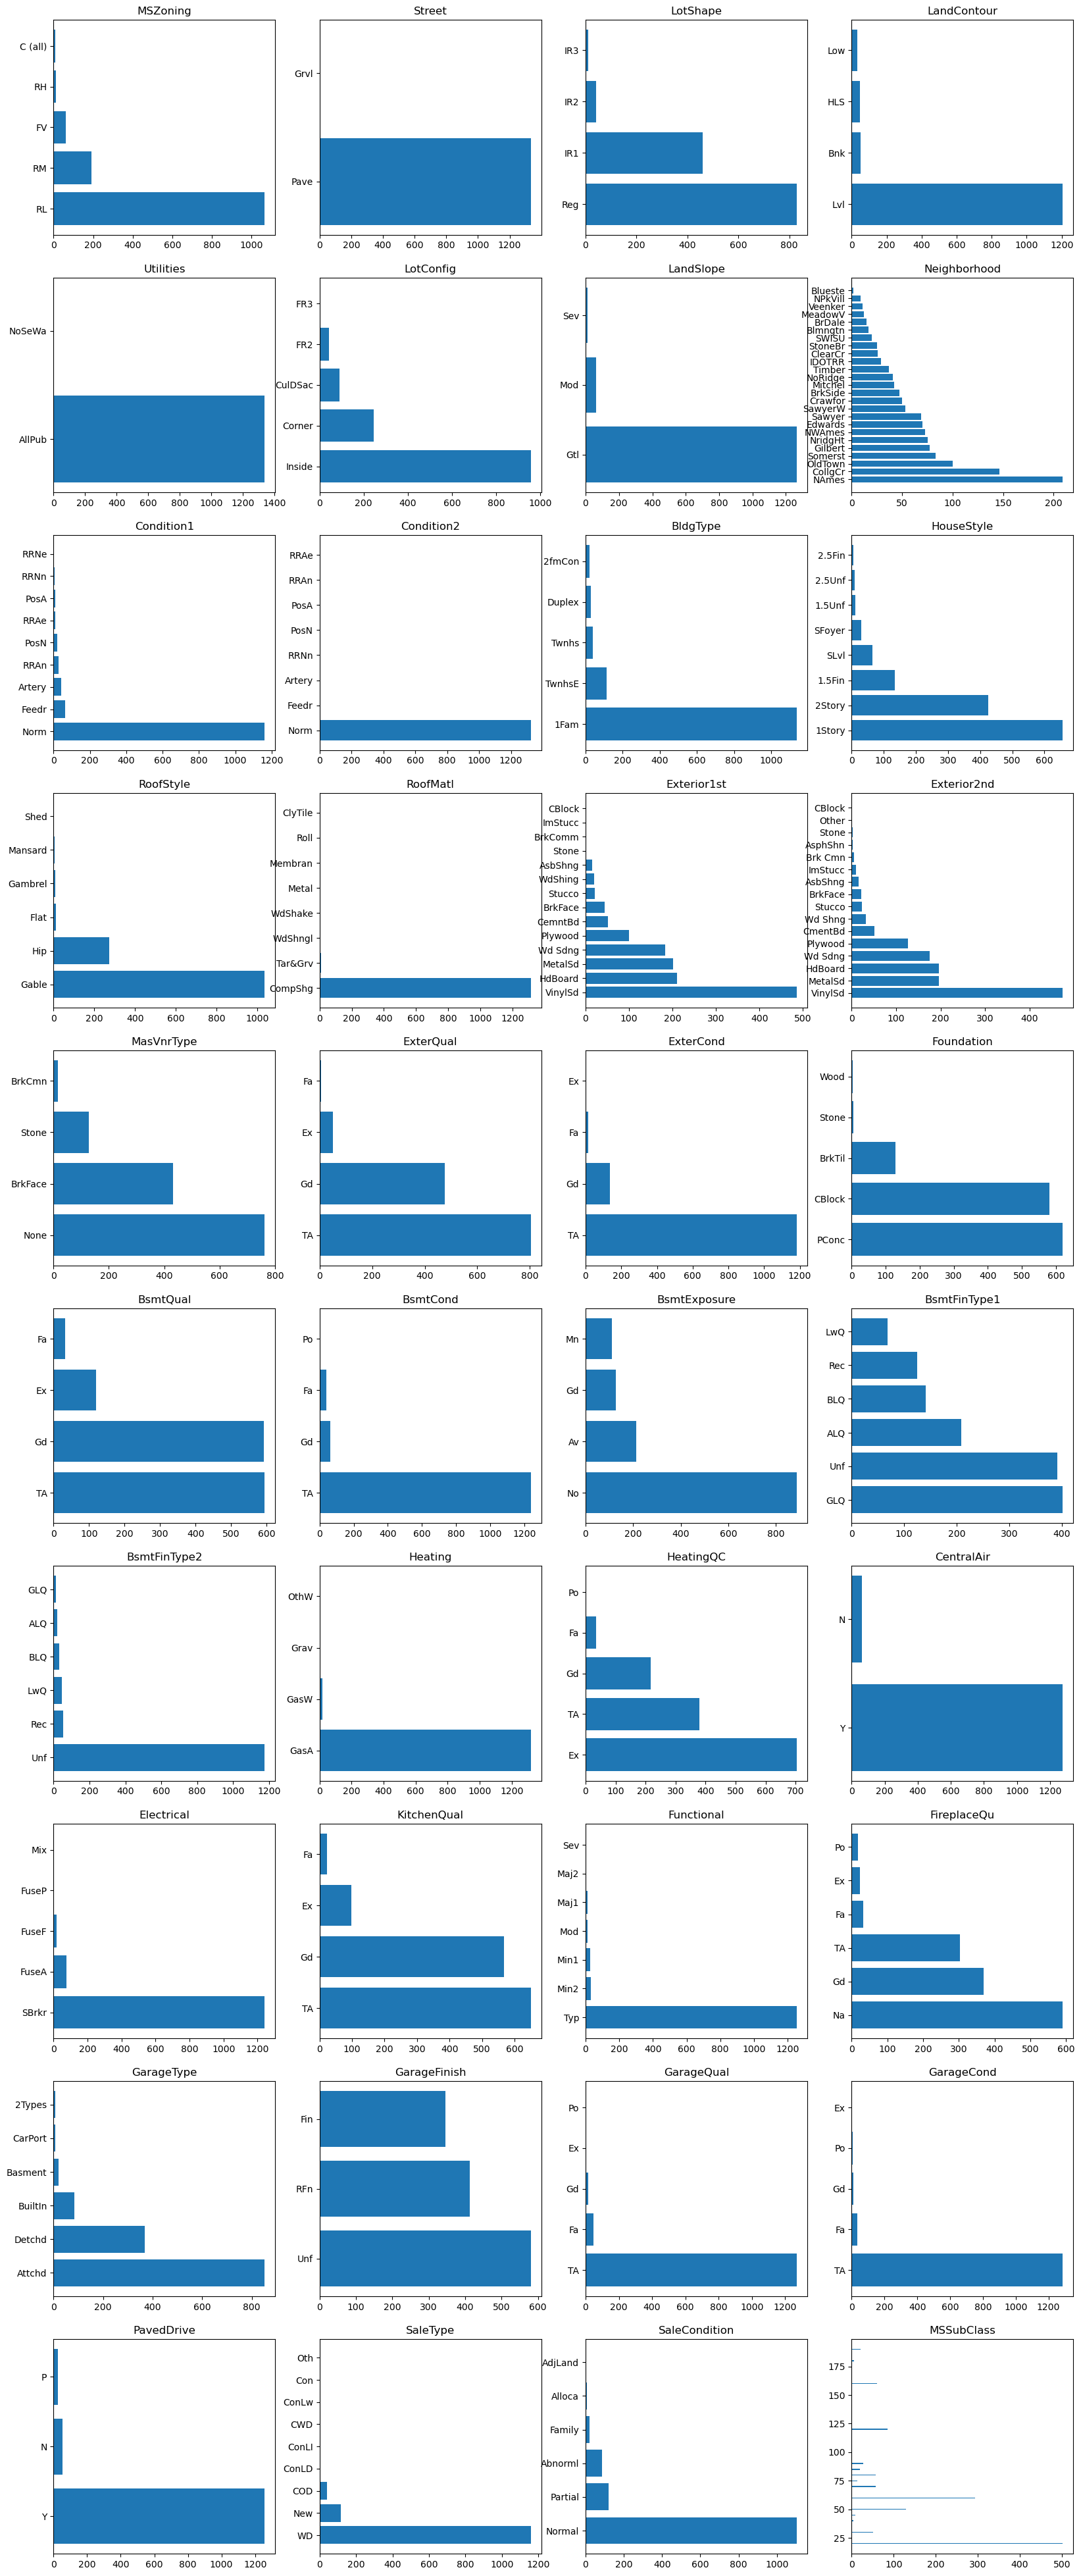

In [24]:
fig, axes = plt.subplots(10, 4, figsize = (20, 50))

for col, ax in zip(categorical_col, axes.flatten()):
    data = df[col].value_counts()
    ax.barh(data.index, data.values)
    ax.set_title(col)

Phân bố dữ liệu trong các cột categorical được chia thành 2 nhóm:

- Các cột dữ liệu phân bố đều, đối với các cột này, nhóm sẽ loại bỏ các dòng thuộc về không quá 5% dữ liệu
 
- Các cột dữ liệu chỉ tập trung vào một class, các class khác rất ít, đối với các cột này, nhóm chỉ đơn giản loại bỏ cột do không có ý nghĩa trong việc xây dựng mô hình

(219, 63)

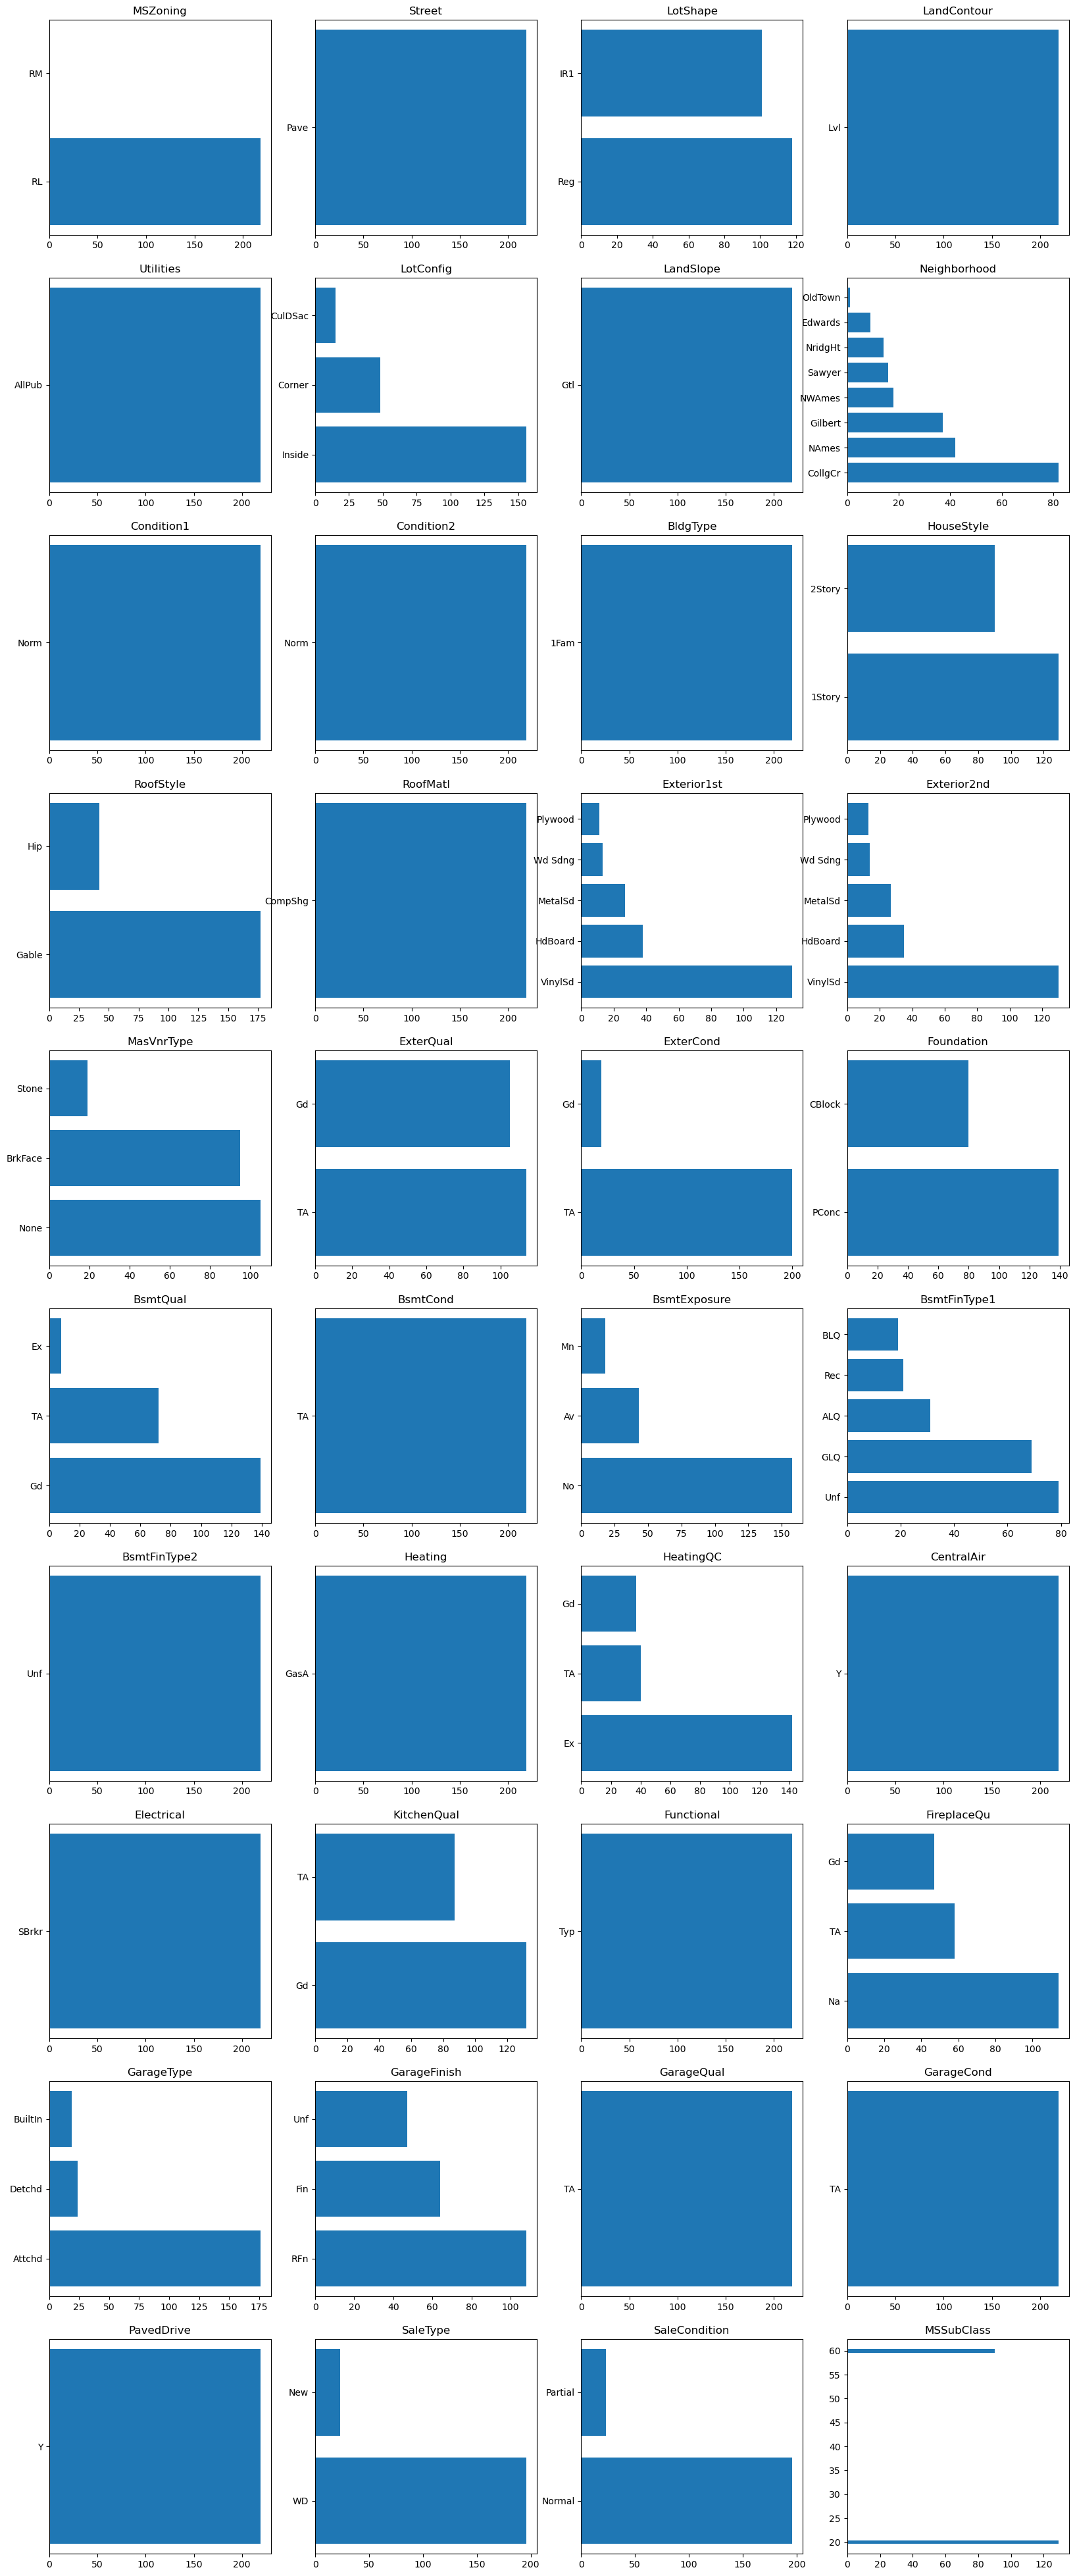

In [25]:
df1 = df

for col in categorical_col:
    temp = df1[col].value_counts()
    df1 = df1[~df1[col].isin(temp[temp <= 0.05 * df1.shape[0]].index)]

fig, axes = plt.subplots(10, 4, figsize = (20, 50))

for col, ax in zip(categorical_col, axes.flatten()):
    data = df1[col].value_counts()
    ax.barh(data.index, data.values)
    ax.set_title(col)

df1.shape

Khi thực hiện loại bỏ các giá trị thuộc về ít hơn 5% trong từng cột, nhóm nhận ra dữ liệu chỉ còn hơn 200 dòng. Do đó thay vì loại bỏ các hàng oulier này, nhóm sẽ giữ nguyên, chỉ bỏ đi các cột mà dữ liệu chỉ tập trung vào một giá trị

In [26]:
df = df.drop(columns = [
    "Street", "LandContour", "Utilities", "LandSlope",
    "Condition1", "Condition2", "BldgType", "RoofMatl",
    "BsmtCond", "BsmtFinType2", "Heating", "CentralAir",
    "Electrical", "Functional", "GarageQual", "GarageCond",
    "PavedDrive"
])

### 1.3.2. Numerical outliers

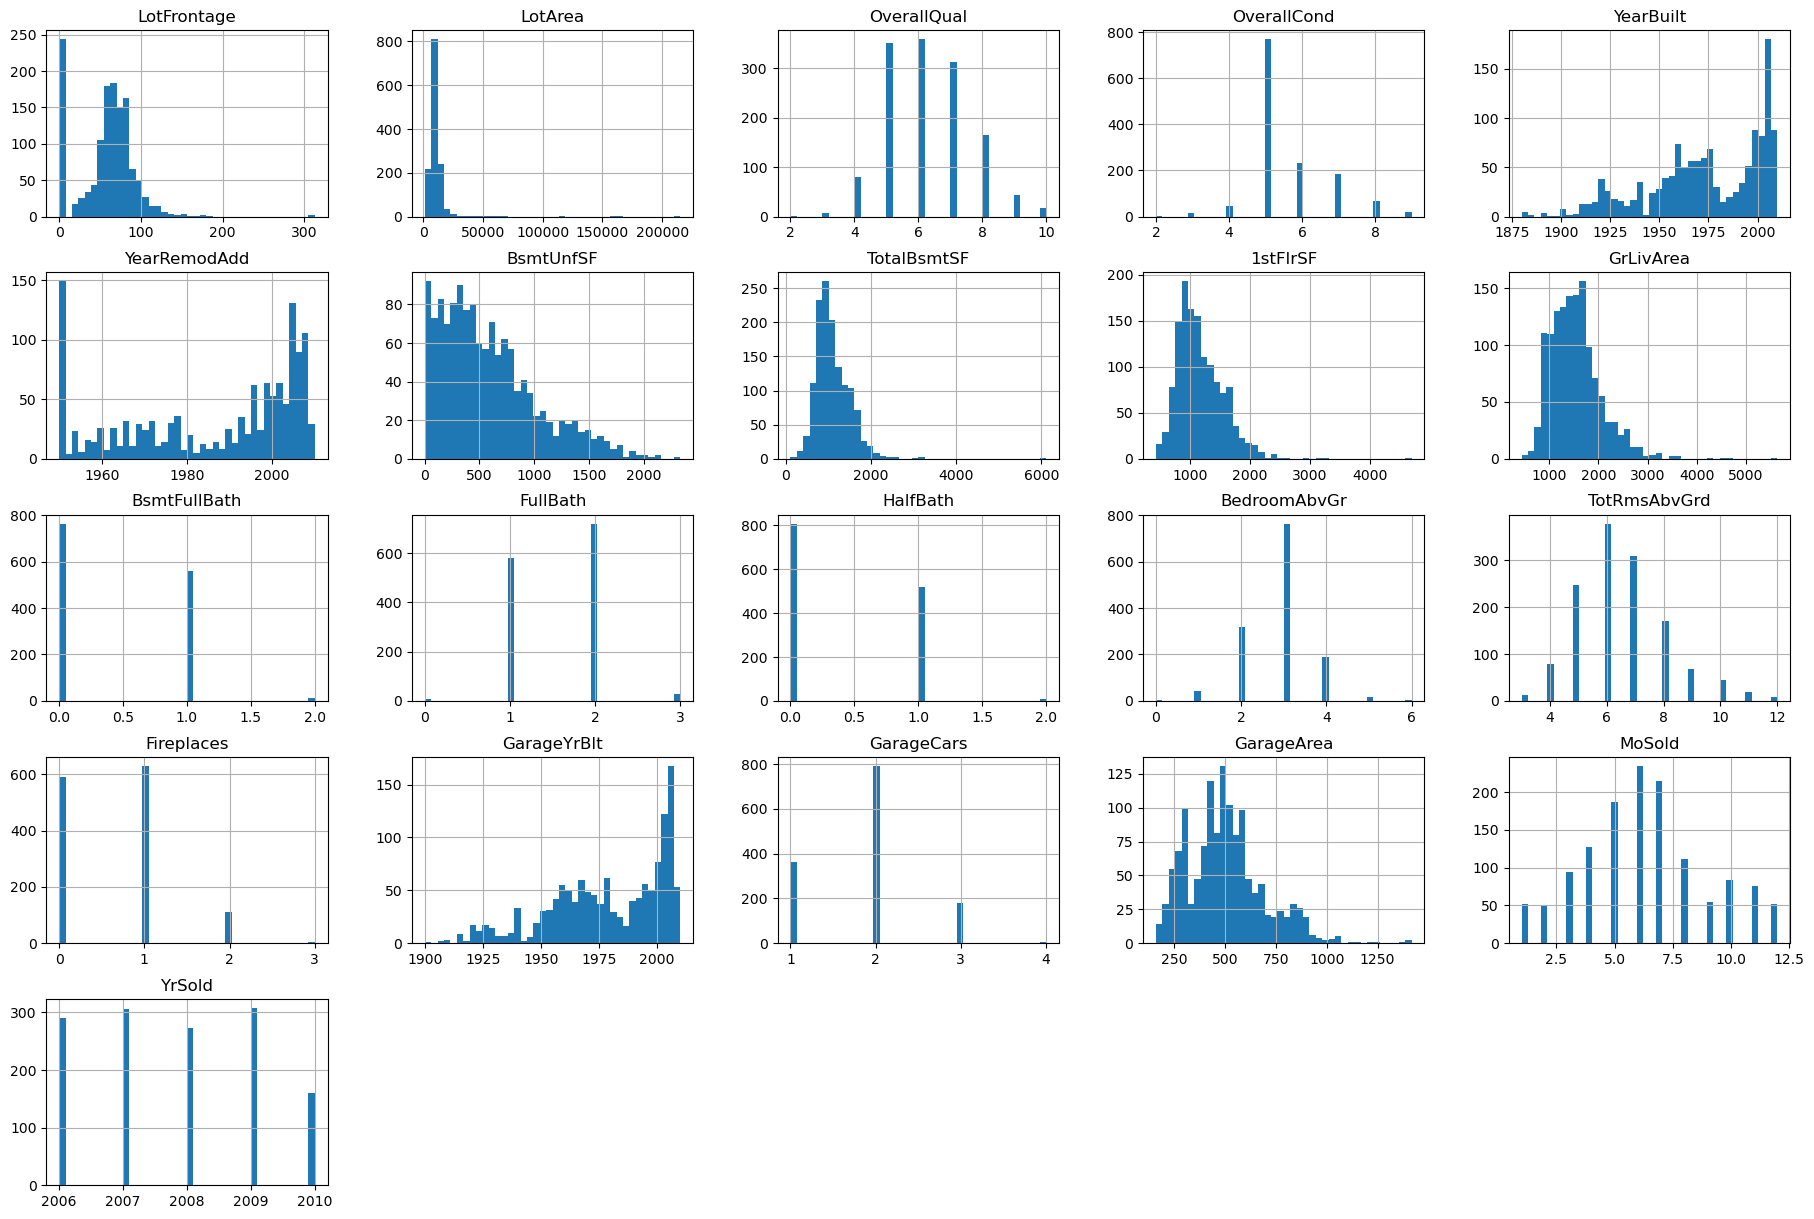

In [27]:
df[numerical_col].hist(bins = 40, figsize = (22.5, 15));

In [28]:
for col in numerical_col:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    df = df[(df[col] > (q1 - 2 * iqr)) & (df[col] < (q3 + 2 * iqr))]

df.shape

(1113, 46)

Sau khi loại bỏ các outlier, dữ liệu còn lại 1113 dòng và 47 cột

# 2.Data Analyzing

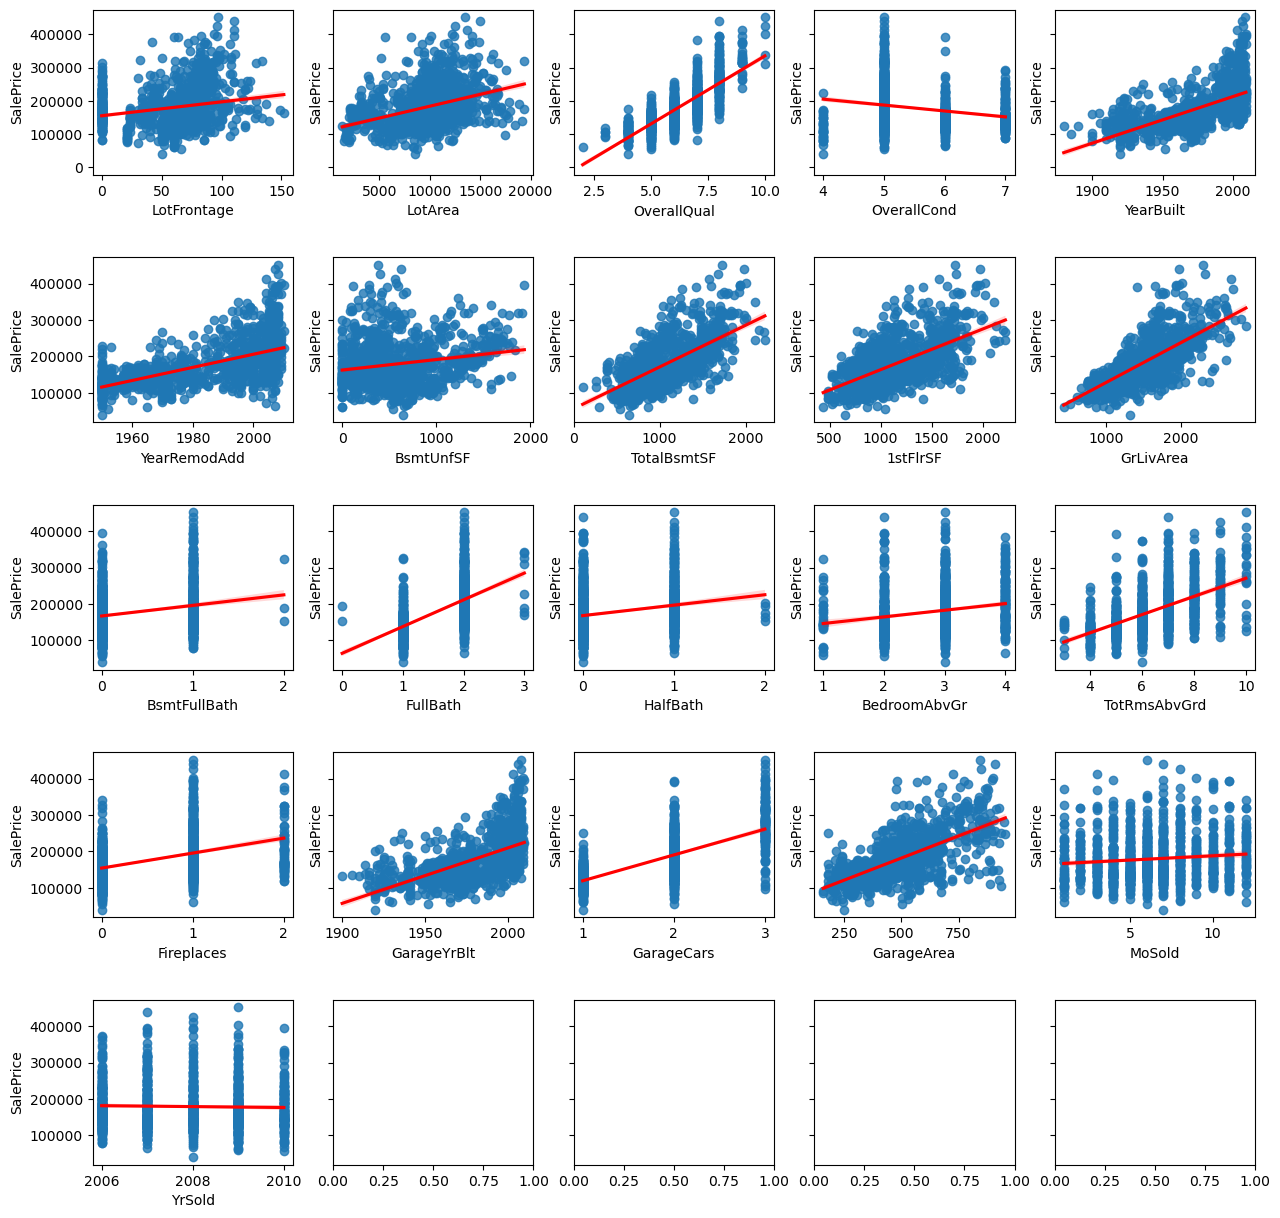

In [29]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15), sharey = "row")
fig.subplots_adjust(hspace = 0.5)

for col, ax in zip(numerical_col, axes.flatten()):
    sns.regplot(x = col, y = "SalePrice", data = df, ax = ax, line_kws = {"color": "red"})

In [30]:
correlation = pd.DataFrame(
    {
        "col": numerical_col,
        "corr": [df[col].corr(df["SalePrice"]) for col in numerical_col]
    }
)

correlation

,col,corr
0,LotFrontage,0.214421
1,LotArea,0.366422
2,OverallQual,0.809231
3,OverallCond,-0.219869
4,YearBuilt,0.622384
5,YearRemodAdd,0.579474
6,BsmtUnfSF,0.195438
7,TotalBsmtSF,0.619579
8,1stFlrSF,0.590084
9,GrLivArea,0.717964


Trong số các cột numerical, chỉ có một số cột có tương quan với cột `SalePrice`. Quan sát biểu đồ scatter và hệ số tương quan, nhóm quyết định chỉ lọc sử dụng các cột có giá trị tuyệt đối của hệ số tương quan lớn hơn hoặc bằng 0.3 cho mục đích xây dựng mô hình

In [31]:
drop_col = list(correlation[abs(correlation["corr"]) < 0.3]["col"].values)
df = df.drop(columns = drop_col)

In [32]:
df.to_csv("../data/preprocessed.csv", index = False)